# Object detection and boundingbox

In [ ]:
import cv2
import numpy as np

# Paths to YOLO model files
weights_path = "yolov3.weights"  # Path to weights file
config_path = "yolov3.cfg"       # Path to configuration file
coco_names_path = "coco.names"  # Path to COCO names file

# Load class names
with open(coco_names_path, "r") as f:
    class_names = f.read().strip().split("\n")

# Load the network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the image
image_path = "cat_dog2.jpg"  # Path to your cat and dog image
image = cv2.imread(image_path)

(H, W) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Get layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Forward pass
layer_outputs = net.forward(ln)

boxes = []
confidences = []
class_ids = []

for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-maximum suppression
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

if len(idxs) > 0:
    for i in idxs.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in np.random.randint(0, 255, size=(3,))]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Save the output image
output_path = "output2.jpg"  # Specify the path and filename for the output
cv2.imwrite(output_path, image)
print(f"Output saved to {output_path}")

# Optionally, display the output
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Output saved to output2.jpg


# Semantic segmentation

## Download the model

In [2]:
import requests

url = "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth"
model_path = "deeplabv3_resnet101_coco.pth"  # Save location

print("Downloading model...")
response = requests.get(url, stream=True)
with open(model_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
print(f"Model downloaded and saved as {model_path}")


Model downloaded and saved as deeplabv3_resnet101_coco.pth


In [4]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101

# Path to the downloaded weights file
model_weights = "deeplabv3_resnet101_coco.pth"

# Load the model structure
model = deeplabv3_resnet101()

# Load the pre-trained weights, ignoring "aux_classifier"
pretrained_dict = torch.load(model_weights)

# Filter out keys that don't match the model
filtered_dict = {k: v for k, v in pretrained_dict.items() if "aux_classifier" not in k}

# Load the filtered state_dict into the model
model.load_state_dict(filtered_dict, strict=False)
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully, ignoring aux_classifier!")


Model loaded successfully, ignoring aux_classifier!


## Load the model

In [5]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101

# Path to the downloaded weights file
model_weights = "deeplabv3_resnet101_coco.pth"

# Load the model structure
model = deeplabv3_resnet101()

# Load pre-trained weights
model.load_state_dict(torch.load(model_weights))
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully!")


RuntimeError: Error(s) in loading state_dict for DeepLabV3:
	Unexpected key(s) in state_dict: "aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias". 

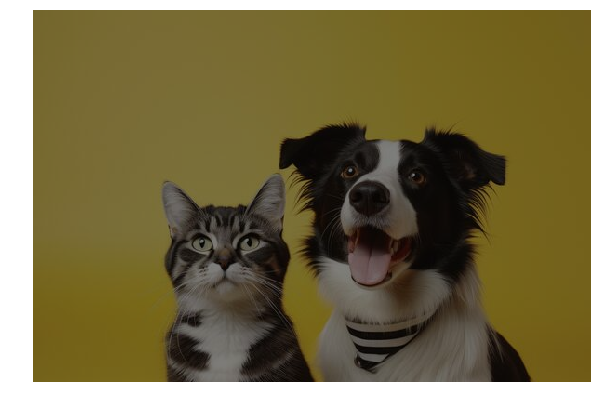

Segmentation output saved as segmentation_output.png


In [4]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained DeepLabV3 model
model_weights_path = "deeplabv3_resnet101_coco.pth"  # Path to downloaded weights

# Initialize the model
model = deeplabv3_resnet101()

# Load weights, ignoring aux_classifier
pretrained_dict = torch.load(model_weights_path, map_location=torch.device('cpu'))
filtered_dict = {k: v for k, v in pretrained_dict.items() if "aux_classifier" not in k}
model.load_state_dict(filtered_dict, strict=False)
model.eval()  # Set to evaluation mode

# Define the COCO dataset classes
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "N/A", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A",
    "N/A", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "N/A", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table", "N/A", "N/A",
    "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "N/A", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]

# Load an image
image_path = "cat_dog.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Filter for "cat" and "dog" classes (COCO IDs: 17 and 18)
mask_cat = (output_predictions == 17)  # Class 17: cat
mask_dog = (output_predictions == 18)  # Class 18: dog

# Combine masks for visualization
segmentation_mask = np.zeros_like(output_predictions, dtype=np.uint8)
segmentation_mask[mask_cat] = 1
segmentation_mask[mask_dog] = 2

# Visualize the results
colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])  # Background, Cat (red), Dog (green)
segmentation_overlay = colors[segmentation_mask]

# # Overlay on original image
# overlay = Image.fromarray(segmentation_overlay).convert("RGBA")
# original_image = image.convert("RGBA")
# blended = Image.blend(original_image, overlay, alpha=0.5)

# Convert the segmentation overlay into a PIL image and blend it with the original image
segmentation_overlay_image = Image.fromarray(segmentation_overlay.astype(np.uint8))
original_image = image.convert("RGBA")
segmented_image = Image.blend(original_image, segmentation_overlay_image.convert("RGBA"), alpha=0.5)


# Show and save the output
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.axis("off")
plt.show()

# Save the blended image
segmented_image.save("segmentation_output.png")
print("Segmentation output saved as segmentation_output.png")


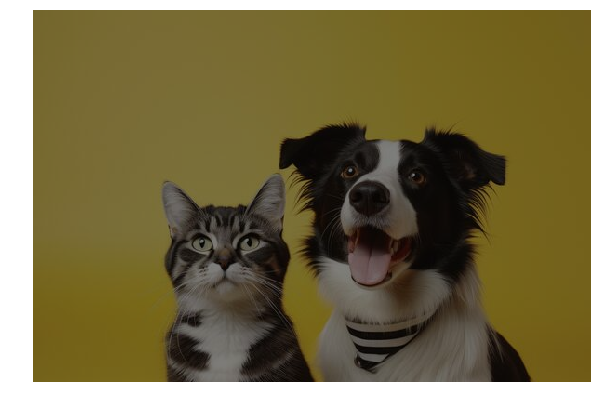

Segmentation output saved as segmentation_output.png


In [5]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained DeepLabV3 model
model_weights_path = "deeplabv3_resnet101_coco.pth"  # Path to downloaded weights

# Initialize the model
model = deeplabv3_resnet101()

# Load weights, ignoring aux_classifier
pretrained_dict = torch.load(model_weights_path, map_location=torch.device('cpu'))
filtered_dict = {k: v for k, v in pretrained_dict.items() if "aux_classifier" not in k}
model.load_state_dict(filtered_dict, strict=False)
model.eval()  # Set to evaluation mode

# Define the COCO dataset classes
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "N/A", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A",
    "N/A", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "N/A", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table", "N/A", "N/A",
    "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "N/A", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]

# Preprocess the image
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Filter for "cat" and "dog" classes (COCO IDs: 17 and 18)
mask_cat = (output_predictions == 17)  # Class 17: cat
mask_dog = (output_predictions == 18)  # Class 18: dog

# Combine masks for visualization
segmentation_mask = np.zeros_like(output_predictions, dtype=np.uint8)
segmentation_mask[mask_cat] = 1  # Mark cat pixels as 1
segmentation_mask[mask_dog] = 2  # Mark dog pixels as 2

# Create a color map for the segmentation: Black for background, Red for cat, Green for dog
colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])  # [Background, Cat (red), Dog (green)]
segmentation_overlay = colors[segmentation_mask].astype(np.uint8)

# Convert the segmentation overlay into a PIL image and blend it with the original image
segmentation_overlay_image = Image.fromarray(segmentation_overlay)
original_image = image.convert("RGBA")
segmented_image = Image.blend(original_image, segmentation_overlay_image.convert("RGBA"), alpha=0.5)

# Show the output
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.axis("off")
plt.show()

# Save the blended image
segmented_image.save("segmentation_output.png")
print("Segmentation output saved as segmentation_output.png")

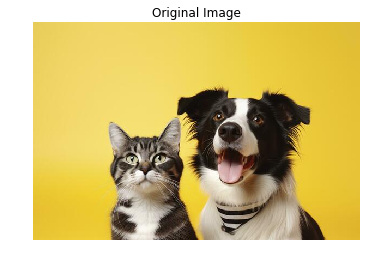

Output predictions shape: (256, 256)
Unique class IDs in the output: [ 0  8 12]
Detected class labels: ['background', 'truck', 'N/A']
Detected cats: 0
Detected dogs: 0


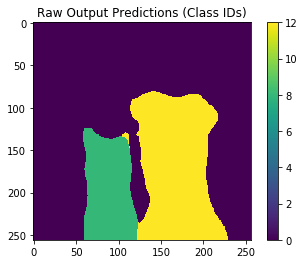

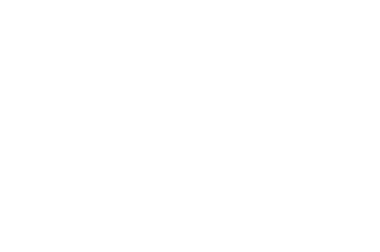

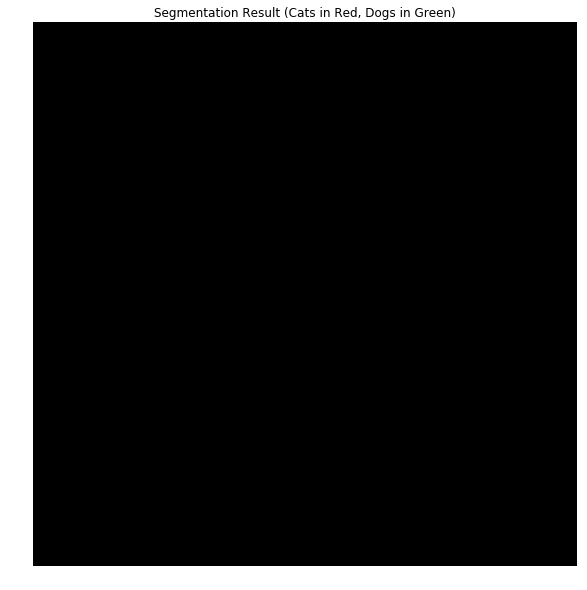

Segmentation output saved as segmentation_output.png


In [16]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load an image
image_path = "cat_dog.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Debugging: Show original image
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Preprocess the image: Resize to 256x256, Normalize, and convert to tensor
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to 256x256
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained model
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Debugging: Check the raw output before post-processing
output_predictions = output.argmax(0).cpu().numpy()

# Debugging: Check output predictions shape and unique classes detected
print(f"Output predictions shape: {output_predictions.shape}")
print(f"Unique class IDs in the output: {np.unique(output_predictions)}")

# Define the COCO classes
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "N/A", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A",
    "N/A", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "N/A", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table", "N/A", "N/A",
    "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "N/A", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]

# Debugging: Check the class names detected
detected_classes = np.unique(output_predictions)
detected_class_names = [COCO_CLASSES[class_id] for class_id in detected_classes]
print(f"Detected class labels: {detected_class_names}")

# Filter for "cat" and "dog" classes (COCO IDs: 17 and 18)
mask_cat = (output_predictions == 17)  # Class 17: cat
mask_dog = (output_predictions == 18)  # Class 18: dog

# Debugging: Check if cats or dogs are detected
print(f"Detected cats: {np.sum(mask_cat)}")
print(f"Detected dogs: {np.sum(mask_dog)}")

fig = plt.figure(frameon=False)

# If no cats or dogs are detected, display the raw class predictions
if np.sum(mask_cat) == 0 and np.sum(mask_dog) == 0:
    plt.imshow(output_predictions)
    plt.title("Raw Output Predictions (Class IDs)")
    plt.colorbar()
    plt.show()
#     plt.imshow(img)
    plt.axis('off')
    fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

# Create a new image where the pixels corresponding to cats and dogs are colored
segmentation_result = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3), dtype=np.uint8)

# Assign colors to the masks
segmentation_result[mask_cat] = [255, 0, 0]  # Red for cat
segmentation_result[mask_dog] = [0, 255, 0]  # Green for dog

# Convert the result to a PIL image
segmentation_result_image = Image.fromarray(segmentation_result)

# Show the segmentation result
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_result_image)
plt.title('Segmentation Result (Cats in Red, Dogs in Green)')
plt.axis("off")
plt.show()

# Save the segmentation result
segmentation_result_image.save("segmentation_output.png")
print("Segmentation output saved as segmentation_output.png")


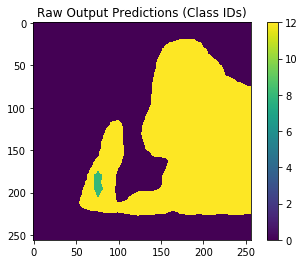

Output predictions shape: (256, 256)
Unique class IDs in the output: [ 0  8 12]
Detected class labels: ['background', 'truck', 'N/A']
Detected cats: 0
Detected dogs: 0


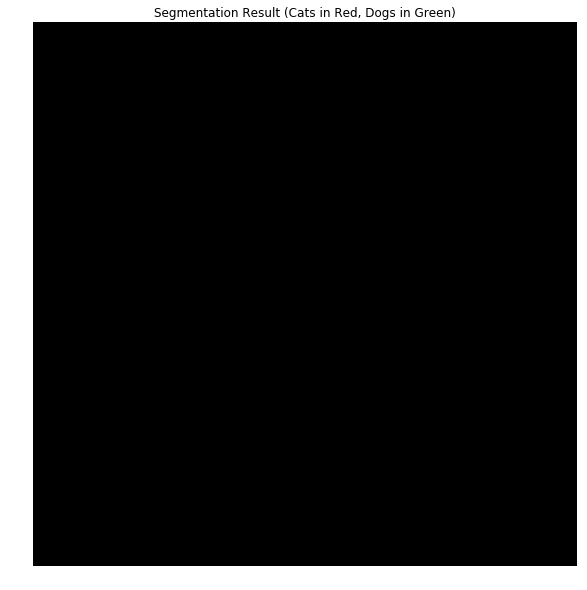

Segmentation output saved as segmentation_output.png


In [14]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load an image
image_path = "cat_dog2.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image: Resize to 256x256, Normalize, and convert to tensor
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to 256x256
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained model
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Get the output predictions (argmax along the channels)
output_predictions = output.argmax(0).cpu().numpy()

# Debugging: Check the raw output predictions
plt.imshow(output_predictions)
plt.title("Raw Output Predictions (Class IDs)")
plt.colorbar()  # Show colorbar to inspect the class IDs visually
plt.show()

# Debugging: Check the unique class IDs detected
print(f"Output predictions shape: {output_predictions.shape}")
print(f"Unique class IDs in the output: {np.unique(output_predictions)}")

# Define the COCO classes
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "N/A", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A",
    "N/A", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "N/A", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "N/A", "dining table", "N/A", "N/A",
    "toilet", "N/A", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "N/A", "book", "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]

# Check if any of the cats or dogs are detected
detected_classes = np.unique(output_predictions)
detected_class_names = [COCO_CLASSES[class_id] for class_id in detected_classes]
print(f"Detected class labels: {detected_class_names}")

# Filter for "cat" and "dog" classes (COCO IDs: 17 and 18)
mask_cat = (output_predictions == 17)  # Class 17: cat
mask_dog = (output_predictions == 18)  # Class 18: dog

# Check if cats or dogs are detected
print(f"Detected cats: {np.sum(mask_cat)}")
print(f"Detected dogs: {np.sum(mask_dog)}")

# Create a new image where the pixels corresponding to cats and dogs are colored
segmentation_result = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3), dtype=np.uint8)

# Assign colors to the masks
segmentation_result[mask_cat] = [255, 0, 0]  # Red for cat
segmentation_result[mask_dog] = [0, 255, 0]  # Green for dog

# Convert the result to a PIL image and visualize
segmentation_result_image = Image.fromarray(segmentation_result)
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_result_image)
plt.title('Segmentation Result (Cats in Red, Dogs in Green)')
plt.axis("off")
plt.show()

# Save the segmentation result
segmentation_result_image.save("segmentation_output.png")
print("Segmentation output saved as segmentation_output.png")


In [ ]:
import cv2
import numpy as np

# Load YOLO model
weights_path = "yolov3.weights"  # Path to weights file
config_path = "yolov3.cfg"       # Path to configuration file
coco_names_path = "coco.names"  # Path to COCO names file

# Load class names
with open(coco_names_path, "r") as f:
    class_names = f.read().strip().split("\n")

# Load the network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Set up video capture
cap = cv2.VideoCapture(0)  # Use webcam (change to file path for video input)

# Process each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get layer names
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # Forward pass
    layer_outputs = net.forward(ln)

    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Non-maximum suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in np.random.randint(0, 255, size=(3,))]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
